In [1]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Road Detection" "/content/Dataset"

Mounted at /gdrive


In [50]:
import os
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.metrics import MeanIoU
import imageio
from PIL import Image
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = '/content/Dataset/'
image_path = os.path.join(path, 'OriginalFrames/')
mask_path = os.path.join(path, 'ColoredMasks/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [4]:
image_list = sorted(image_list)
mask_list = sorted(mask_list)

In [5]:
len(image_list)

701

In [6]:
len(mask_list)

701

Text(0.5, 1.0, 'Segmentation')

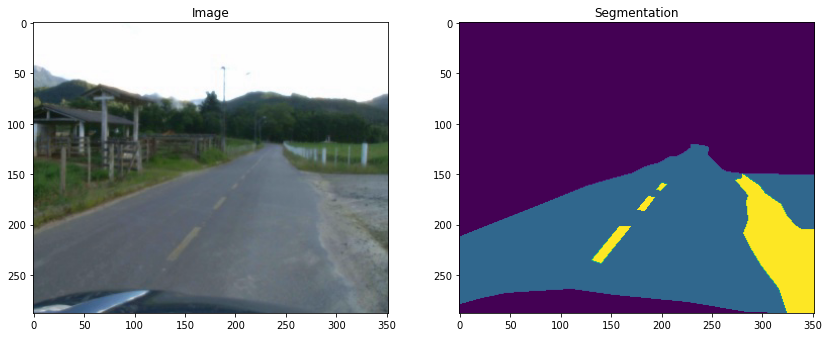

In [7]:
N = 3
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [8]:
images = []
for i in range(len(image_list)):
    img = Image.open(image_list[i])
    img = img.resize((176, 144))
    img = asarray(img)
    images.append(img)

In [9]:
masks = []
for i in range(len(mask_list)):
    mask = Image.open(mask_list[i])
    mask = mask.resize((176, 144))
    mask = asarray(mask)
    masks.append(mask)

In [10]:
images = np.array(images)
masks = np.array(masks)

(701, 144, 176, 3)


Text(0.5, 1.0, 'Segmentation')

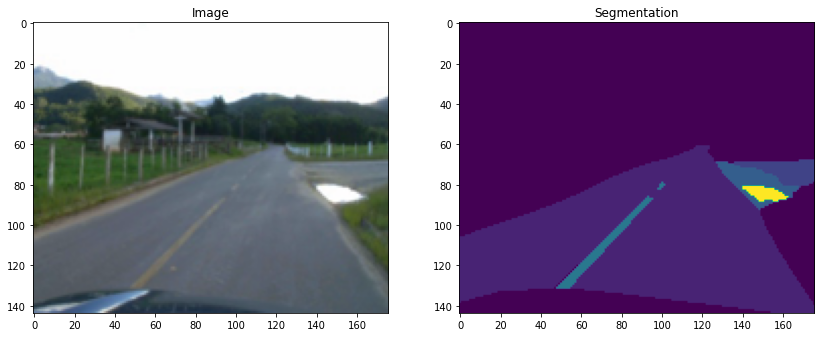

In [11]:
image = images[0]
mask = masks[0]
print(images.shape)
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(image)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

In [12]:
def mask_to_categorical(masks, n_classes):
  print(np.unique(masks))
  masks_cat = to_categorical(masks, num_classes = n_classes)
  print(masks_cat.shape)
  print(np.unique(masks_cat))
  return masks_cat

In [13]:
masks_cat = mask_to_categorical(masks, 13)

[ 0  1  2  3  4  5  6  7  9 10 11 12]
(701, 144, 176, 13)
[0. 1.]


In [14]:
def multi_unet_model(n_classes=13, IMG_HEIGHT=144, IMG_WIDTH=176, IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [15]:
img_height = 144
img_width = 176
num_channels = 3
num_classes = 13
unet = multi_unet_model(n_classes=num_classes, IMG_HEIGHT=img_height, IMG_WIDTH=img_width, IMG_CHANNELS=num_channels)

In [16]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 144, 176, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 144, 176, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [17]:
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(images, masks_cat, test_size=0.2)

In [39]:
EPOCHS = 20
BATCH_SIZE = 32
history = unet.fit(X_train, y_train, batch_size=BATCH_SIZE, verbose = 1, epochs=EPOCHS)

Epoch 1/20
18/18 [==============================] - 3s 142ms/step - loss: 0.0171 - accuracy: 0.9664
Epoch 2/20
18/18 [==============================] - 3s 144ms/step - loss: 0.0165 - accuracy: 0.9673
Epoch 3/20
18/18 [==============================] - 3s 145ms/step - loss: 0.0158 - accuracy: 0.9685
Epoch 4/20
18/18 [==============================] - 3s 146ms/step - loss: 0.0152 - accuracy: 0.9692
Epoch 5/20
18/18 [==============================] - 3s 146ms/step - loss: 0.0150 - accuracy: 0.9698
Epoch 6/20
18/18 [==============================] - 3s 146ms/step - loss: 0.0151 - accuracy: 0.9696
Epoch 7/20
18/18 [==============================] - 3s 148ms/step - loss: 0.0148 - accuracy: 0.9702
Epoch 8/20
18/18 [==============================] - 3s 145ms/step - loss: 0.0145 - accuracy: 0.9701
Epoch 9/20
18/18 [==============================] - 3s 148ms/step - loss: 0.0142 - accuracy: 0.9706
Epoch 10/20
18/18 [==============================] - 3s 147ms/step - loss: 0.0143 - accuracy: 0.9707

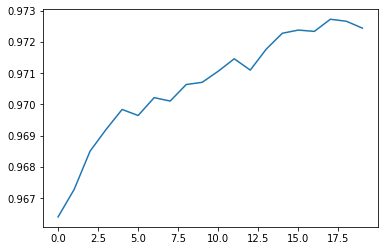

In [40]:
plt.plot(history.history["accuracy"])

In [43]:
def predictions(model, x_test):
  y_pred = model.predict(x_test)
  y_pred_class = np.argmax(y_pred, axis=3)
  print(y_pred_class.shape)
  return y_pred_class

In [44]:
y_pred_class = predictions(unet, X_test)

5/5 [==============================] - 0s 60ms/step
(141, 144, 176)


In [45]:
y_test_class =  np.argmax(y_test, axis=3)

In [48]:
def meanIoU(y_pred_class, y_test_class, n_classes):
  IoU = MeanIoU(num_classes=13)
  IoU.update_state(y_test_class, y_pred_class)
  print(IoU.result().numpy())

In [49]:
meanIoU(y_pred_class, y_test_class, 13)

0.26527408
